In [41]:
import torch#
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import sys
import time
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix
from matplotlib import rcParams  # フォント設定用
rcParams['font.family'] = 'Times New Roman'

In [42]:
batch_size = 64
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
                                ])

tf_train = transforms.Compose([
    transforms.RandomCrop(28, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
tf_test  = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

root = os.path.join(onedrive_path,'CODES','samples','Fmnist_data')
Fmnist_train = datasets.FashionMNIST(root=root,download=True,train=True,transform=tf_train)
Fmnist_test = datasets.FashionMNIST(root=root,download=True,train=False,transform=tf_test)
test_dataloader = DataLoader(Fmnist_test,batch_size=batch_size,shuffle=False)

In [43]:
def get_new_dataloader(Fmnist_train,batch_size):
    train_dataloader = DataLoader(Fmnist_train,batch_size=batch_size,shuffle=True)
    return train_dataloader

In [44]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

Using device: cpu


In [45]:
def split_into_kernels(image, kernel_size):

    b,c,h,w = image.shape
    kernels = image.unfold(2, kernel_size, kernel_size).unfold(3, kernel_size, kernel_size)
    kernels = kernels.contiguous().view(b, -1, kernel_size, kernel_size) #(b,p,k,k)

    return kernels

In [46]:
class Encoder(nn.Module):
    def __init__(self,kernel_size,leverage,channels):
        super(Encoder, self).__init__()
        self.kernel_size = kernel_size
        self.leverage = leverage
        kernel_in = kernel_size ** 2 * channels
        output_dim = int(kernel_in/leverage)
        phase = torch.rand(output_dim, kernel_in) * 2 * np.pi - np.pi
        modulus = torch.ones(output_dim, kernel_in)
        real_part = modulus * torch.cos(phase)
        imag_part = modulus * torch.sin(phase)
        self.B = torch.complex(real_part, imag_part).detach().to(device)
        self.B.requires_grad = False
        self.alpha = torch.rand(kernel_in) * 0.5 + 0.5  #<<<<<<<<<<<<<<<<<
        self.alpha = self.alpha.detach().to(device)#<<<<<<<<<<<<<<<<<<<<<<
        self.alpha.requires_grad = False#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
    def forward(self, x):
        b, n_patches,  k, _ = x.shape
        x = x.reshape(b*n_patches, -1)
        x = torch.exp(1j * self.alpha * x) 
        x = x.T  
        x = torch.matmul(self.B, x).T 
        x = torch.abs(x)**2 
        return x

In [47]:
class CNN(nn.Module):
    def __init__(self,img_size,channels):
        super(CNN, self).__init__()
        ch1 = 16
        ch2 = 32
        self.conv1 = nn.Conv2d(channels, ch1, kernel_size=3, padding=1)
        # 32チャネル -> 64チャネル
        self.conv2 = nn.Conv2d(ch1, ch2, kernel_size=3, padding=1)
        # プーリング層
        self.pool = nn.MaxPool2d(2, 2)

        self.norm1 = nn.BatchNorm2d(ch1)
        self.norm2 = nn.BatchNorm2d(ch2)
        self.fc1 = nn.Linear(ch2 * (img_size//4) * (img_size//4), 256)
        self.fc2 = nn.Linear(256, 10)  # 10クラス
        self.func = nn.ReLU()
    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.func(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.norm2(x)
        x = self.func(x)
        x = self.pool(x)  # conv2 → ReLU → Pool
        x = x.view(x.size(0), -1)  # フラット化 (batch, 64*8*8)= nn.MaxPool2d(2, 2)
        # 全結合層
        x = self.func(self.fc1(x))          # 全結合1 → ReLU
        x = self.fc2(x)              # 全結合2 (出力)
        return x


In [48]:
class EncoderClassifier(nn.Module):
    def __init__(self, img_size,channels, kernel_size, leverage):
        super(EncoderClassifier, self).__init__()

        self.img_size = img_size
        self.channels = channels
        self.kernel_size = kernel_size
        
        kernel_in = channels*kernel_size**2
        feat_dim = int(kernel_in/leverage)
        n_patches = (28//kernel_size)*(28//kernel_size)
        self.side = int(np.sqrt(n_patches))

        self.split = split_into_kernels
        self.encoder = Encoder(kernel_size,leverage,channels) 
        self.bn = nn.BatchNorm2d(feat_dim)#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        self.classifier =  CNN(self.side,feat_dim)
        
    def forward(self, x):
        b=x.size(0)
        x = x.view(b, self.channels, self.img_size, self.img_size)  
        x = self.split(x, self.kernel_size) 
        x = self.encoder(x)
        x = x.view(b, self.side, self.side, -1).permute(0, 3, 1, 2)  
        #print(x.shape)
        x = self.bn(x)
        x = self.classifier(x)
        return x

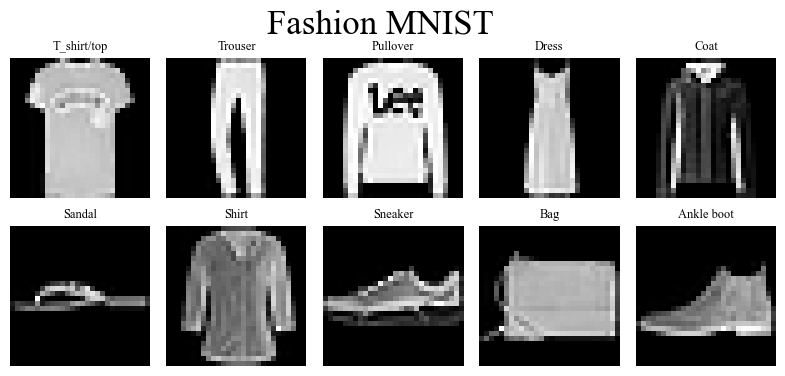

In [49]:
#MNISTのイメージを表示するやつ
def show_images(images, labels, title):
    images = images.view(images.size(0), 1, 28, 28)
    np.set_printoptions(precision=2)
    images = images.detach().numpy()
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    axes = axes.flatten()  
    fashion_labels = [
    "T_shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
    ]
    selected_digits = range(10) ##
    selected_indices = [] 
    for digit in selected_digits:
        idx = (labels == digit).nonzero(as_tuple=True)[0]
        if len(idx) > 0:
            selected_indices.append(idx[0].item())
    for i, ax in enumerate(axes):
        if i < len(selected_indices):
            ax.imshow(images[selected_indices[i], 0], cmap='gray')
            ax.set_title(fashion_labels[i], fontsize=9)
        ax.axis('off')
    plt.subplots_adjust(wspace=0.05)
    plt.suptitle(title,fontsize=25,y=1)

for i, (test_images, test_labels) in enumerate(test_dataloader):
    if i == 0:##
        break
show_images(test_images, test_labels,"Fashion MNIST")

1/5th Time Epoch: 20/20

Test Accuracy: 76.91%
loss_train: 0.6358,loss_test: 0.5985
LOSS:0.5985
ProcessingTime: 150.4551727771759


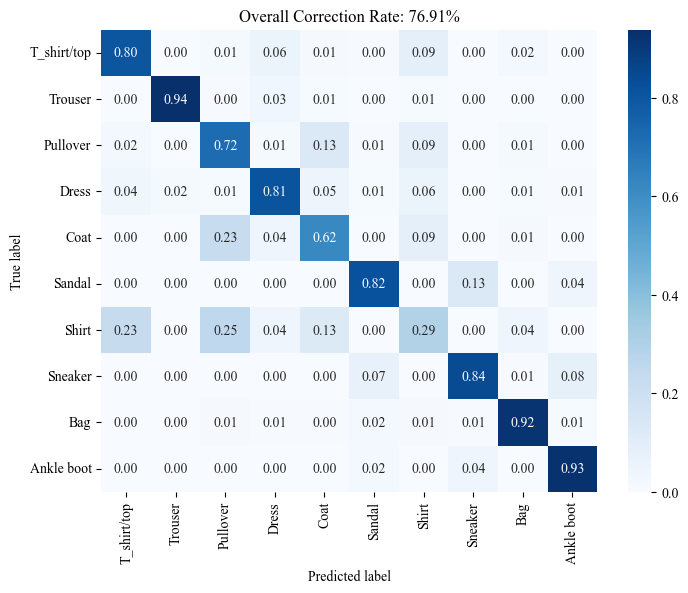

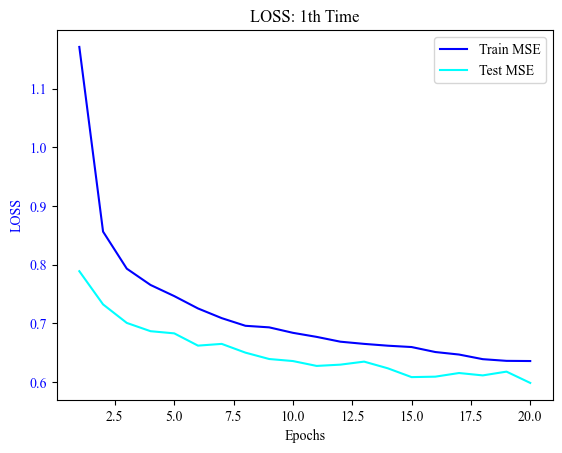

2/5th Time Epoch: 20/20

Test Accuracy: 73.99%
loss_train: 0.6959,loss_test: 0.6678
LOSS:0.6678
ProcessingTime: 149.65610814094543


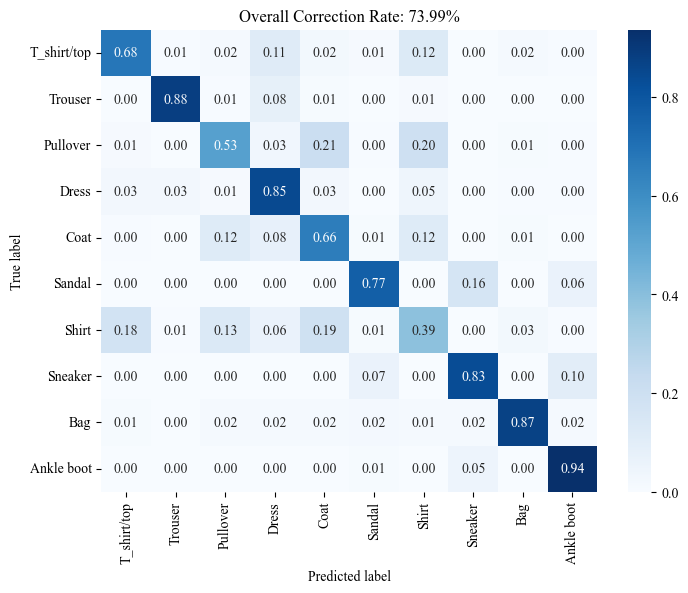

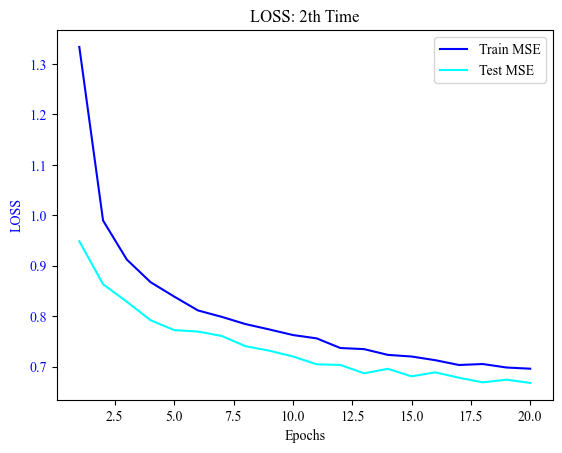

3/5th Time Epoch: 20/20

Test Accuracy: 73.13%
loss_train: 0.7458,loss_test: 0.6906
LOSS:0.6906
ProcessingTime: 150.87562489509583


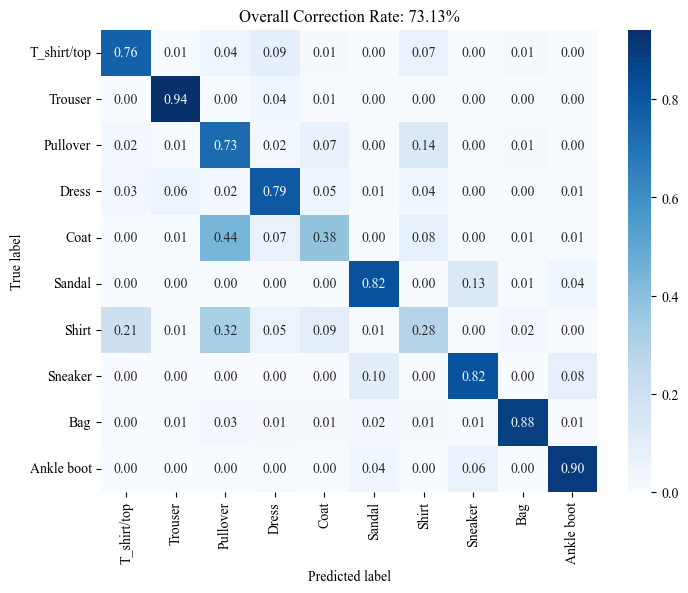

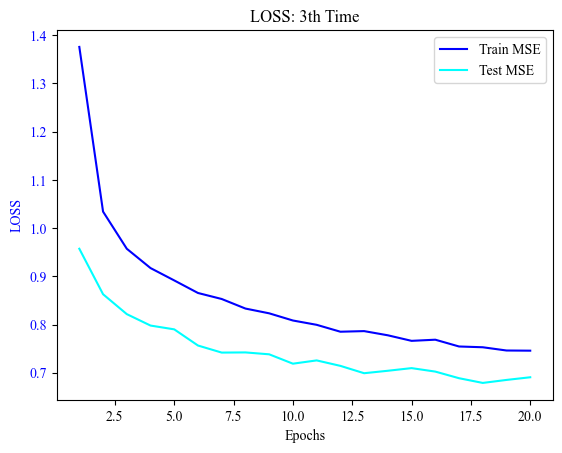

4/5th Time Epoch: 20/20

Test Accuracy: 75.13%
loss_train: 0.7054,loss_test: 0.6593
LOSS:0.6593
ProcessingTime: 149.2225615978241


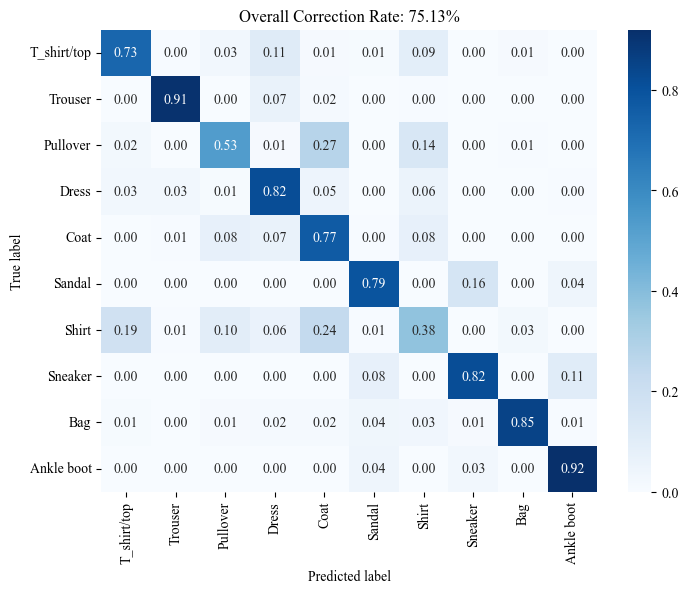

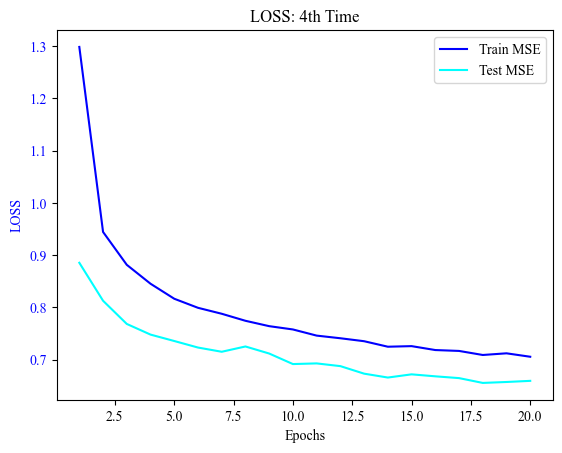

5/5th Time Epoch: 20/20

Test Accuracy: 73.66%
loss_train: 0.7439,loss_test: 0.6874
LOSS:0.6874
ProcessingTime: 149.3020510673523


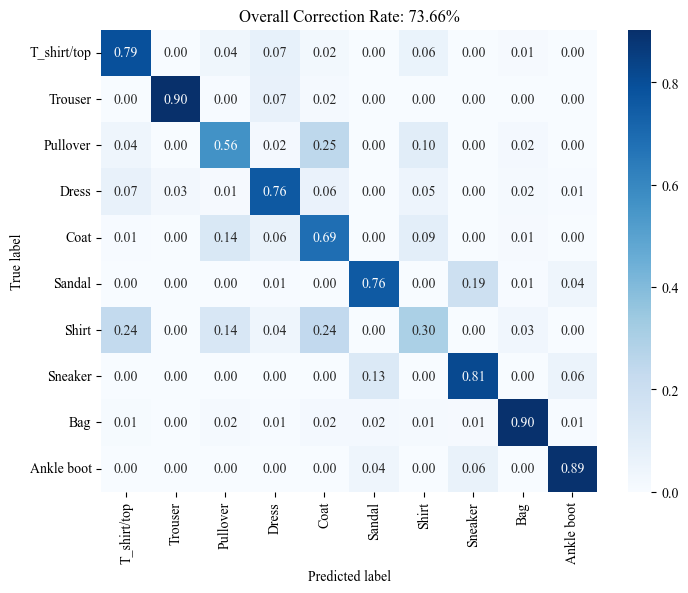

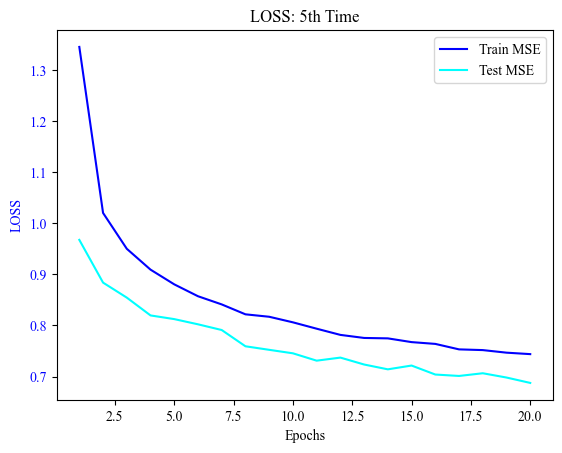

In [ ]:
channels = 1
img_size = 28
kernel_size = 4
max_epochs = 20##10
leverage = 8
kernel_size = 4

num_try = 5##5

All_last_loss = []
All_loss_test = []
All_pro_time = []
All_test_acc = []

for num_times in range(num_try): 

    train_dataloader = get_new_dataloader(Fmnist_train,batch_size)
    model = EncoderClassifier(img_size,channels, kernel_size, leverage).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=3e-4, weight_decay=1e-4)
    
    loss_train_ = []
    loss_test_ = []
    pro_time_ = []

            
    for epoch in range(max_epochs):

        sys.stderr.write('\r%d/%dth Time Epoch: %d/%d' % (num_times+1,num_try, epoch+1, max_epochs)) 
        sys.stderr.flush()

        loss_train = 0
        loss_test = 0

        start_time1 = time.time()
        for (x,t) in train_dataloader:
                    
            x, t = x.to(device), t.to(device)
            y = model(x).to(device)
            loss = criterion(y, t) 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

       
        loss_train_avg = loss_train / len(train_dataloader)
        end_time1 = time.time()
        pro_time_.append(end_time1-start_time1)


        with torch.no_grad():
            all_preds = []
            all_labels = []
            correct = 0
            total = 0
            for x, t in test_dataloader:
                x, t = x.to(device), t.to(device)
                y = model(x).to(device)
                _, predicted = torch.max(y, 1)
                loss = criterion(y,t)
                loss_test += loss.item()        
                total += t.size(0)
                correct += (predicted == t).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(t.cpu().numpy())

        loss_test_avg = loss_test / len(test_dataloader)

        loss_train_.append(loss_train_avg)
        loss_test_.append(loss_test_avg)
        #if epoch == max_epochs-1:
    All_loss_test.append(loss_test_)
    All_pro_time.append(sum(pro_time_)) 

    cm = confusion_matrix(all_labels, all_preds)
    cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # 正規化（行ごとに割合に）

    Last_loss_test = loss_test_[-1]
    All_last_loss.append(Last_loss_test)
    All_test_acc.append(100 * correct / total)
    print(f"Test Accuracy: {100 * correct / total:.2f}%")
    print(f"loss_train: {loss_train_avg:.4f},loss_test: {loss_test_avg:.4f}")
    print(f"LOSS:{Last_loss_test:.4f}")
    print('ProcessingTime:',sum(pro_time_))

    fashion_labels = [
    "T_shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
    ]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                 xticklabels=fashion_labels, yticklabels=fashion_labels,
                 vmin=0.0, vmax=1.0)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(f"Overall Correction Rate: {100 * correct / total:.2f}%")
    plt.show()

    fig, ax1 = plt.subplots()
    ax1.plot(range(1,len(loss_train_)+1), loss_train_, label="Train MSE", color = 'blue')
    ax1.plot(range(1,len(loss_test_)+1), loss_test_, label="Test MSE", color = 'cyan')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('LOSS', color = 'blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend()

    title = 'LOSS: %dth Time'%(num_times+1) #
    plt.title(title)
    plt.show()


In [51]:
ACC_mean = np.mean(All_test_acc)
ACC_best = np.max(All_test_acc)
ACC_bestID = np.argmax(All_test_acc)+1
ACC_worst = np.min(All_test_acc)
ACC_worstID = np.argmin(All_test_acc)+1

LOSS_mean = np.mean(All_last_loss)
LOSS_best = np.min(All_last_loss)
LOSS_bestID = np.argmin(All_last_loss)+1
LOSS_worst = np.max(All_last_loss)
LOSS_worstID = np.argmax(All_last_loss)+1

data = {
        "": ["ACC", "LOSS"],
    "Average": [ACC_mean, LOSS_mean],
    "Best ID": [ACC_bestID, LOSS_bestID],
    "Best": [ACC_best, LOSS_best],
    "Worst ID": [ACC_worstID, LOSS_worstID],
    "Worst": [ACC_worst, LOSS_worst],
}

df = pd.DataFrame(data)

print(df)


          Average  Best ID      Best  Worst ID      Worst
0   ACC  74.56400        1  76.91000         3  73.130000
1  LOSS   0.66072        1   0.59848         3   0.690634


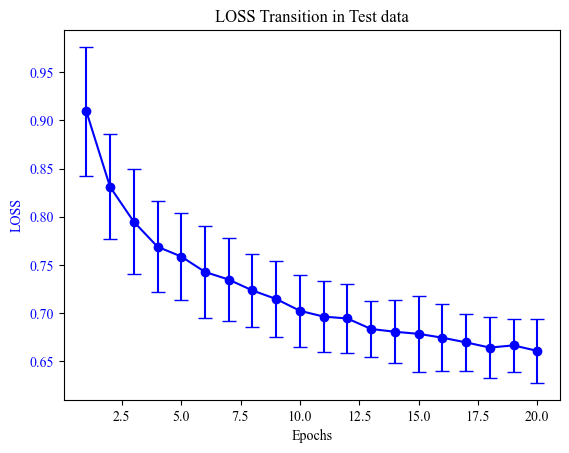

In [52]:
epochs = len(All_loss_test[0])  # エポック数（各リストの長さ）
num_dimensions = len(All_loss_test)  # 埋め込み次元数の数

# 各エポックごとに平均と標準偏差を計算
mean_loss = np.mean(All_loss_test, axis=0)
std_loss = np.std(All_loss_test, axis=0)

# グラフの描画
fig, ax1 = plt.subplots()

# 平均値の折れ線グラフと誤差範囲（標準偏差の誤差棒）
ax1.errorbar(
    x=range(1, epochs + 1), y=mean_loss, yerr=std_loss,
    fmt='-o', color='blue', ecolor='blue', capsize=5, 
)

# 軸ラベルやタイトルの設定
ax1.set_xlabel('Epochs')
ax1.set_ylabel('LOSS', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.title('LOSS Transition in Test data')
plt.show()

In [54]:
import csv
save_directory1 = os.path.join(onedrive_path,'CODES', 'konishi_Classifer', 'data','FMNIST_texts') 
print(save_directory1)
os.makedirs(save_directory1, exist_ok=True)
file_name = 'CNN_PM_Class00_list.csv'##
full_path = os.path.join(save_directory1, file_name)
with open(full_path, mode='w', newline='') as file:
    writer = csv.writer(file)

    writer.writerow(All_loss_test)

/Users/konishi/OneDrive/CODES/konishi_Classifer/data/FMNIST_texts
